# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1871 sha256=e62df39180cb7e2aaad902741f57197939bdecf02ba968d5816f66ddb1418825
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

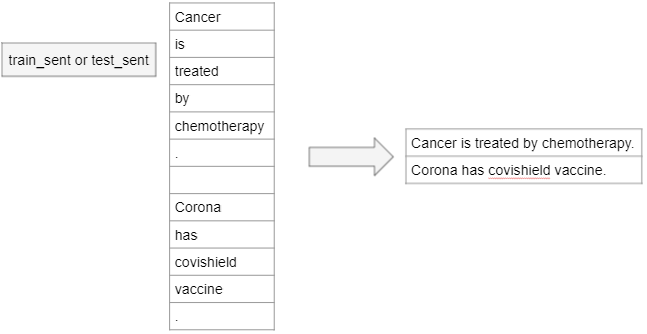

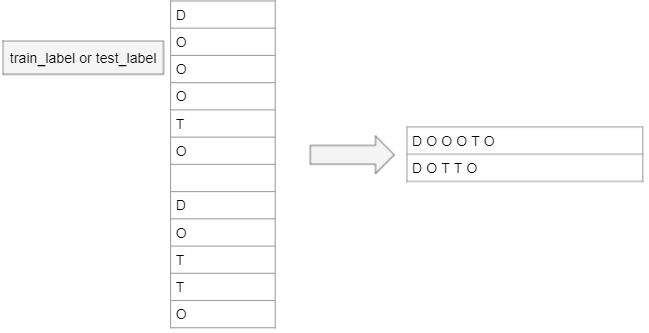



To process a corpus where each word is provided one line at a time, and then construct complete sentences from it, I have created a function named unpack_given_file. This function takes the filename as input, reads each word line by line, and assembles sentences. It returns a list of sentences to the calling module.

Each sentence is created by grouping words until a punctuation mark (e.g., period) is encountered, which signifies the end of a sentence.

In [3]:
def unpack_given_file(file_name):
    """This function reads a file and unpacks its lines to form sentences, returning a list of sentences."""
    with open(file_name, 'r') as file:
        data = file.read().splitlines()  # Read all lines and remove newline characters
    sentences, temp_sentence = [], []

    for line in data:
        if line:  # Non-empty line
            temp_sentence.append(line)
        else:  # Empty line encountered
            if temp_sentence:
                sentences.append(" ".join(temp_sentence))  # Form a sentence from accumulated lines
                temp_sentence = []  # Reset temporary list

    if temp_sentence:  # Add any remaining sentence if file doesn't end with an empty line
        sentences.append(" ".join(temp_sentence))

    return sentences


In [ ]:
# Unpacking the train sentences
train_set = unpack_given_file('train_sent')

# Displaying 5 sentences from indices 10 to 14
sample_sentences = train_set[10:15]
sample_sentences


['A 2- , 3- , and 4-day mean temperature prior to the test date was compared to AFI using a Spearman-rank Correlation',
 'This relationship should be taken into account when interpreting the AFI as a measure of fetal well-being',
 'The study population included 84 women with gestational diabetes , ascertained by universal screening of all women attending the antenatal clinic of the Hadassah Medical Center , over a 2-year period',
 "The 60 women ( 71 % ) , who initiated treatment before 34 completed weeks , composed the `` early '' group",
 "The 24 women ( 29 % ) , who initiated treatment after the 34th week , composed the `` late '' group"]

In [5]:
# Unpacking train labels
train_label=unpack_given_file('train_label')
train_label[10:15] # Checking 5 labels from 10-14

['O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O',
 'O O O O O O O D D O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

In [7]:
# Unpacking test sentences
test_set=unpack_given_file('test_sent')
test_set[:5] # Checking first 5 sentences from test sentences

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']

In [8]:
test_label=unpack_given_file('test_label')
test_label[:5] # Checking first 5 labels from test labels

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O']

In [9]:
all_sent = train_set+test_set
len(all_sent)

3655

In [10]:
# Combining trains and test labels for Exploratory data analysis
all_labels=train_label+test_label
len(all_labels)

3655

In [11]:
# Creating a dataframe out of the given sentences and labels
df=pd.DataFrame(list(zip(all_sent,all_labels)), columns=['sentences','labels'])
df.head()

,sentences,labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [14]:
# Creating new columns to count occurrences of 'O', 'D', and 'T' tags in each sentence/document
df['O_label'] = df['labels'].str.count('O')
df['D_label'] = df['labels'].str.count('D')
df['T_label'] = df['labels'].str.count('T')

# Displaying the last 15 rows of the dataframe
df.tail(15)


,sentences,labels,O_label,D_label,T_label
3640,Efficacy of open-bite treatment with the Thera...,O O D O O O T,5,1,1
3641,Hepatic arterial infusion of chemotherapy afte...,O O O O T O T O D D O D D,7,4,2
3642,Evidence for double resistance to permethrin a...,O O O O O T T T O D D,6,2,3
3643,Urgent colonoscopy for the diagnosis and treat...,O T O O O O O O D D D,7,3,1
3644,"Effects of tolcapone , a catechol-O-methyltran...",O O T T T T T O O O O O O O T O O O D D D O,13,3,6
3645,"Dry powdered formoterol , twice a day versus a...",T T T O O O O O T T O O O O O O O O O D D,14,2,5
3646,Celecoxib for arthritis,T O D,1,1,1
3647,Poliomyelitis prevention : revised recommendat...,D O O O O O O O O O O O D T,11,2,1
3648,Brimonidine tartrate 0.2 % twice daily vs timo...,T T O O O O O T O O O O O O O O D O,14,1,3
3649,Epoetin : a pharmacoeconomic review of its use...,T O O O O O O O O D D D O O O O O O O,15,3,1


In [15]:
df.describe()

,O_label,D_label,T_label
count,3655.000000,3655.000000,3655.000000
mean,15.269494,1.337620,1.045417
std,12.396386,2.109442,2.377397
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,21.000000,2.000000,1.000000
max,125.000000,34.000000,30.000000


In [16]:
df.shape

(3655, 5)

In [17]:
df.info

<bound method DataFrame.info of                                               sentences  \
0     All live births > or = 23 weeks at the Univers...   
1     The total cesarean rate was 14.4 % ( 344 of 23...   
2     Abnormal presentation was the most common indi...   
3     The `` corrected '' cesarean rate ( maternal-f...   
4     Arrest of dilation was the most common indicat...   
...                                                 ...   
3650  Reduction of vasoreactivity and thrombogenicit...   
3651  Effects of ultrasound energy on total peripher...   
3652  High-dose chemotherapy with autologous stem-ce...   
3653  `` Tandem '' high-dose chemoradiotherapy with ...   
3654  Intravenous immune globulin for recurrent spon...   

                                                 labels  O_label  D_label  \
0     O O O O O O O O O O O O O O O O O O O O O O O ...       45        0   
1     O O O O O O O O O O O O O O O O O O O O O O O O O       25        0   
2                         O O O O O O O O O O O O O O O       15        0   
3     O O O O O O O O O O O O O O O O O O O O O O O ...       38        0   
4           O O O O O O O O O O O O O O O O O O O O O O       22        0   
...                                                 ...      ...      ...   
3650                          O O D O D O T T O O O T T        7        2   
3651                    O O T T O D D D D O O O O O O O       10        4   
3652                                T T T T T T O D D D        1        3   
3653              T T T T T T T T T O O O O O O O O D D        8        2   
3654                                      T T T O D D D        1        3   

      T_label  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
3650        4  
3651        2  
3652        6  
3653        9  
3654        3  

[3655 rows x 5 columns]>

In [18]:
df[df.T_label>25]

,sentences,labels,O_label,D_label,T_label
2037,only the combination of a cell wall-active ant...,O O T T T T T T T T T T T T T T T T T T T T T ...,21,9,30
2090,objective : to examine the effectiveness of ni...,O O O O O O O T T T T T T T T T T T T T T T T ...,9,2,28
2315,A three-step treatment algorithm for refractor...,O O O O O D D O O T T T T T T T T T T T T T T ...,22,2,28


In [19]:
df.T_label.sum()

3821

In [20]:
df.O_label.sum()

55810

In [21]:
df.D_label.sum()

4889

In [22]:
df[(df.T_label==0)&(df.D_label==0)]

,sentences,labels,O_label,D_label,T_label
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,45,0,0
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O,25,0,0
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,15,0,0
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,38,0,0
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,22,0,0
...,...,...,...,...,...
3410,Relatives in the resuscitation room : their po...,O O O O O O O O O O,10,0,0
3412,Subcutaneous autologous ovarian transplantatio...,O O O O O O O O O O,10,0,0
3417,Adolescent pregnancy and sexual abuse,O O O O O,5,0,0
3418,Still hard to know how large the benefits will...,O O O O O O O O O O O,11,0,0


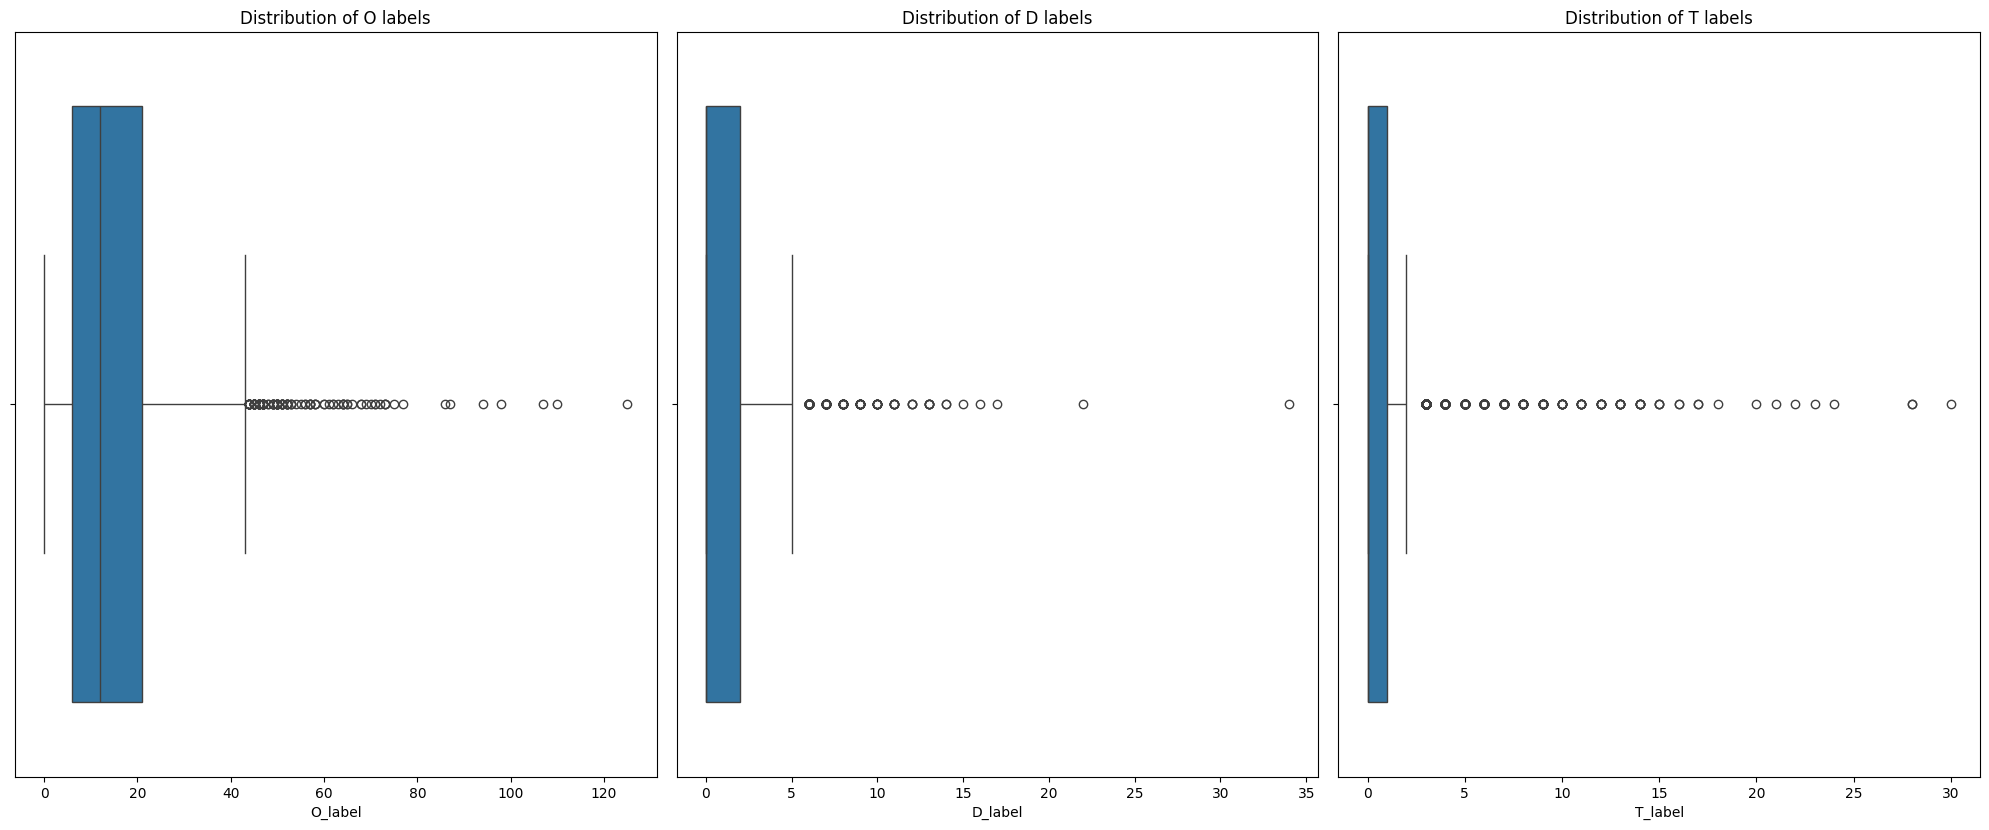

In [23]:
# Setting up the figure and subplots
plt.figure(figsize=(20, 16))

# List of labels and titles for each subplot
labels = ['O_label', 'D_label', 'T_label']
titles = ['Distribution of O labels', 'Distribution of D labels', 'Distribution of T labels']

# Looping through each label to create a boxplot
for i, (label, title) in enumerate(zip(labels, titles), start=1):
    plt.subplot(2, 3, i)
    plt.title(title)
    sns.boxplot(x=df[label])

plt.tight_layout()
plt.show()

During the exploratory data analysis (EDA), we observed the following trends in the label distributions:

O Label Distribution:

Most sentences contain a relatively low count of O labels, generally in the range of 0 to 40.
However, some sentences have a significantly higher count of O labels, exceeding 120 in certain cases, indicating a skewed distribution.
D and T Label Distribution:

The presence of D labels is comparatively sparse across sentences, with fewer occurrences than O.
T labels are even less frequent, suggesting that these labels are rare in the dataset.
These observations align with the output of the .describe() function for each label, which highlights the overall distribution, range, and median counts, confirming that O labels are more prevalent, while D and T labels occur infrequently.

### Count the number of sentences in the processed train and test dataset

In [24]:
print('Number of sentences in the train set: ',len(train_set))
print('Number of sentences in the test set: ',len(test_set))

Number of sentences in the train set:  2599
Number of sentences in the test set:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [25]:
print('Number of labels in the train set: ',len(train_label))
print('Number of labels in the test set: ',len(test_label))

Number of labels in the train set:  2599
Number of labels in the test set:  1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [38]:
# Extracting nouns and proper nouns from all sentences and storing their lemmas in lowercase
noun_or_propn = [
    token.lemma_.lower()
    for review in all_sent
    for token in model(review)
    if token.pos_ in {'NOUN', 'PROPN'}
]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [39]:
pd.Series(noun_or_propn).value_counts().head(25)

,count
patient,568
treatment,316
%,247
study,236
cancer,226
cell,203
therapy,182
effect,181
disease,170
group,145



In examining the top 25 nouns and proper nouns from our data, we observe key terms that reflect the nature of the study. The most frequent words include "cancer," "effects," "therapy," "case study," and "lung," indicating a focus on medical and research topics. Additionally, the term "chemotherapy" appears prominently with 91 occurrences, underscoring its importance in the dataset.

This lexical distribution suggests that the content is likely centered around medical studies or case analyses, particularly in fields related to oncology, therapeutic interventions, and specific research into lung-related conditions. The recurring themes within these terms provide insight into the primary topics covered by the dataset.








In [40]:
dict_of_words=pd.Series(noun_or_propn).value_counts().to_dict()
dict_of_words

{'patient': 568,
 'treatment': 316,
 '%': 247,
 'study': 236,
 'cancer': 226,
 'cell': 203,
 'therapy': 182,
 'effect': 181,
 'disease': 170,
 'group': 145,
 'case': 132,
 'result': 121,
 'lung': 120,
 'gene': 111,
 'year': 105,
 'rate': 103,
 'use': 91,
 'chemotherapy': 91,
 'trial': 90,
 'woman': 89,
 'conclusion': 89,
 'analysis': 86,
 'protein': 82,
 'response': 81,
 'risk': 78,
 'child': 77,
 'dose': 77,
 'mutation': 74,
 'to_see': 74,
 'drug': 74,
 'tumor': 74,
 'surgery': 73,
 'p': 72,
 'method': 70,
 'control': 69,
 'infection': 68,
 'survival': 67,
 'factor': 67,
 'day': 63,
 'evidence': 62,
 'combination': 62,
 'age': 61,
 'health': 61,
 'term': 61,
 'syndrome': 60,
 'activity': 60,
 'management': 56,
 'care': 56,
 'stage': 55,
 'datum': 54,
 'acid': 54,
 'c': 54,
 'month': 54,
 'bone': 53,
 'time': 53,
 'carcinoma': 53,
 'diagnosis': 52,
 'role': 50,
 'practice': 49,
 'week': 48,
 'b': 47,
 'outcome': 46,
 '#': 46,
 'pregnancy': 46,
 'blood': 46,
 'family': 45,
 'heart': 45,

In [41]:
len(noun_or_propn)

24373

As shown 24373 words found that has parts of speech (PoS) tag of nouns or proper nouns from our model

## Defining features for CRF





  Extracts features for a given word at position `pos` in the sentence `sentence`.
    
    Features:
    f1 = Part-of-speech (PoS) tag of the word
    f2 = Word in lower case
    f3 = Last 3 characters of the word
    f4 = Last 2 characters of the word
    f5 = 1 if the word is in uppercase, 0 otherwise
    f6 = 1 if the word is a number, 0 otherwise
    f7 = 1 if the word starts with a capital letter, 0 otherwise
    

In [42]:
# Let's define the features to get the feature value for one word.
# Defining features for one word in the sentence
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    # Extracting the part-of-speech (PoS) tag using the NLP model
    word_pos_tag = model(word)[0].pos_  # Assuming model provides tokenized info for word

    # Initializing the list of features for the current word
    features = [
        'word.postag=' + word_pos_tag,  # f1: PoS tag of the word
        'word.lower=' + word.lower(),  # f2: Word in lowercase
        'word[-3:]=' + word[-3:],  # f3: Last 3 characters of the word
        'word[-2:]=' + word[-2:],  # f4: Last 2 characters of the word
        'word.isupper=%s' % word.isupper(),  # f5: Uppercase check
        'word.isdigit=%s' % word.isdigit(),  # f6: Is the word a number
        'word.startsWithCapital=%s' % word[0].isupper()  # f7: Starts with capital letter
    ]

    # If not the first word, include features from the previous word
    if pos > 0:
        prev_word = sentence[pos - 1]
        prev_word_pos_tag = model(prev_word)[0].pos_  # PoS tag of the previous word
        features.extend([
            'prev_word.postag=' + prev_word_pos_tag,  # Previous word PoS tag
            'prev_word.lower=' + prev_word.lower(),  # Previous word in lowercase
            'prev_word.isupper=%s' % prev_word.isupper(),  # Previous word uppercase check
            'prev_word.isdigit=%s' % prev_word.isdigit(),  # Previous word number check
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper()  # Previous word capital check
        ])
    else:
        features.append('BEG')  # Mark the beginning of the sentence if it's the first word

    # If the word is at the end of the sentence, append 'END'
    if pos == len(sentence) - 1:
        features.append('END')

    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [53]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    """
    This function processes a full sentence and generates features for each word in the sentence.

    It splits the sentence into words, and for each word, it calls `getFeaturesForOneWord` to generate
    the feature set for that word.

    Args:
    sentence (str): The input sentence for which features are to be generated.
    model (spaCy model): The NLP model used to analyze word properties like PoS tagging.

    Returns:
    list: A list of features for each word in the sentence.
    """
    sentence_list = sentence.split()  # Split the sentence into individual words
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]


### Write a code/function to get the labels of a sentence

In [45]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    """
    This function splits a string of space-separated labels into a list of labels.

    Args:
    labels (str): The space-separated labels for a sentence.

    Returns:
    list: A list of labels corresponding to the sentence.
    """
    return labels.split()

In [55]:
model = spacy.load('en_core_web_sm')

# Example sentence from the train set
example_sentence = train_set[5]  # Choosing 6th sentence
print(example_sentence)  # Printing the entire sentence for reference

# Get features for the example sentence (pass the model as an argument)
example_features = getFeaturesForOneSentence(example_sentence)

# Print the features for the 6th word (or any other index of interest)
print(example_features[5])

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age
['word.postag=NOUN', 'word.lower=hospitals', 'word[-3:]=als', 'word[-2:]=ls', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.postag=VERB', 'prev_word.lower=care', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False']


 features are correctly defined for the word hospitals

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [56]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_set]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]

### Define the labels as the target variable for test and the train dataset

In [57]:
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_set]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [58]:
# Build the CRF model.
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)


CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [59]:
Y_pred=crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [60]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9074336155669012

In [61]:
# Testing a sample prediction against actual values
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 1001
id = 1001
print("Sentence:",test_set[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: An active-control trial of lamotrigine monotherapy for partial seizures
Orig Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']
Pred Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']


the record at 1001 sentence is a correct prediction.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

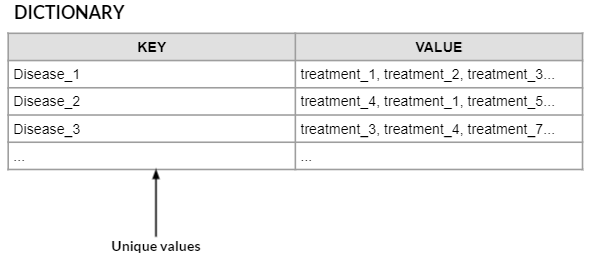

In [62]:


# Initialize the dictionary
disease_treatment_dict = {}

# Loop over the predicted labels (Y_pred) and the corresponding test set sentences (test_set)
for count, labels in enumerate(Y_pred):  # Y_pred contains the predicted labels for each sentence
    temp = "".join(labels)  # Join the labels into a single string (without spaces)

    # Count the occurrences of 'D' (disease) and 'T' (treatment)
    totalD = len(re.findall('D', temp))
    totalT = len(re.findall('T', temp))

    if totalD > 0 and totalT > 0:  # Only proceed if both diseases and treatments are present
        indexD = []  # List to store indices of disease ('D')
        indexT = []  # List to store indices of treatment ('T')

        # Find indices of 'D' (disease labels)
        start_from = 0
        for _ in range(totalD):
            foundat = temp.find('D', start_from)
            indexD.append(foundat)
            start_from = foundat + 1

        # Find indices of 'T' (treatment labels)
        start_from = 0
        for _ in range(totalT):
            foundat = temp.find('T', start_from)
            indexT.append(foundat)
            start_from = foundat + 1

        # Construct the disease string from the indices of 'D'
        disease = ', '.join([test_set[count].split()[i] for i in indexD])

        # Construct the treatment string from the indices of 'T'
        treatment = ', '.join([test_set[count].split()[i] for i in indexT])

        # Add the disease and treatment to the dictionary
        disease_treatment_dict[disease] = treatment

# Print the resulting dictionary
print(disease_treatment_dict)


{'nonimmune, hydrops, fetalis': 'Trisomy', 'hereditary, retinoblastoma': 'radiotherapy', 'unstable, angina, or, non-Q-wave, myocardial, infarction': 'roxithromycin', 'coronary-artery, disease': 'Antichlamydial, antibiotics', 'primary, pulmonary, hypertension, (, PPH, )': 'fenfluramines', 'cellulitis': 'G-CSF, therapy, intravenous, antibiotic, treatment', 'foot, infection': 'G-CSF, treatment', "early, Parkinson, 's, disease": 'Ropinirole, monotherapy', 'sore, throat': 'Antibiotics', 'female, stress, urinary, incontinence': 'surgical, treatment', 'stress, urinary, incontinence': 'therapy', 'preeclampsia, (, proteinuric, hypertension, )': 'intrauterine, insemination, with, donor, sperm, versus, intrauterine, insemination', 'cancer': 'Matrix, metalloproteinase, inhibitors', 'major, pulmonary, embolism': 'Thrombolytic, treatment', 'malignant, pleural, mesothelioma': 'thoracotomy, ,, radiotherapy, ,, and, chemotherapy', 'pulmonary, symptoms': 'chemotherapy', 'non-obstructive, azoospermia': '

In [71]:
df1 = pd.DataFrame(disease_treatment_dict.items(), columns=['disease', 'treatment'])

# Display the first few rows of the dataframe
print(df1.head())

                     disease     treatment
0  hereditary retinoblastoma  radiotherapy
1                   disease1    treatment1
2                   disease2    treatment2


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [73]:
disease_treatment_dict['hereditary retinoblastoma']

'radiotherapy'

Here we can conclude that the treatment for **'heriditary retinoblastoma' is 'radiotherapy'**